# 導入不同策略 根據最新300根k棒產生的買賣序列 進行回測 畫出圖表

,metric
總報酬率,245.94
年化報酬率,期間過短，不適用
日報酬率,6.1414
最大回撤,-48.94
交易次數,16
勝率,75.0
平均持有K棒數,42.38
平均每筆報酬率,10.23


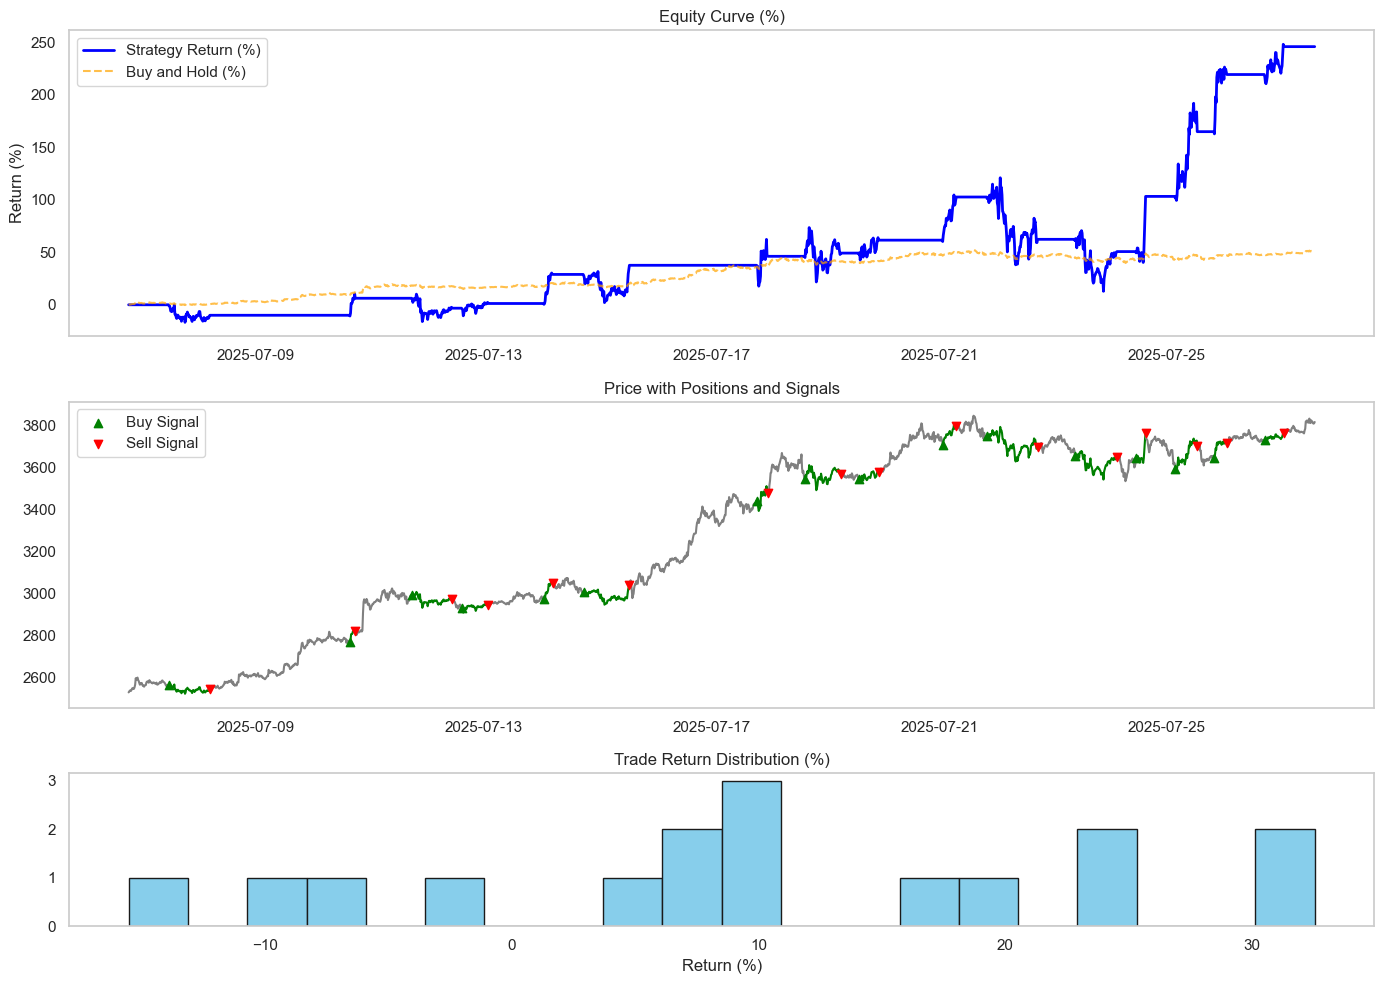

In [11]:
from Technicalindicatorstrategy import stochastic_range_bound,vegas,vegas_adx,sma
from datetime import datetime, timedelta
from Backtest.backtest import backtest_signals
from Plot.plot import plot_backtest_result
import warnings 
warnings.filterwarnings('ignore')
import pandas as pd


df_signals = sma.get_signals('ETHUSDT','15m',datetime.now(),2000,n1 = 60, n2 = 35)

result = backtest_signals(
    df_signals,
    initial_capital=33, #1000台幣
    fee_rate = 0.0004,# 合約（用市價單）
    leverage=10, 
    allow_short=False)

display(pd.DataFrame(result['metric'],index=['metric']).T)
plot_backtest_result(result['fig'])
